In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from Utils import plot_roc_curve, report, plot_lost_history, _confusion_matrix, append_to_binary_results

## Análise exploratória dos dados

In [2]:
df_orginal = pd.read_csv("../Datasets/pulsar_stars.csv")

In [3]:
df_orginal.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
# Validando se existe valores nulos no dataset
df_orginal.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

In [5]:
# Vendo a quantidade de linhas, colunas e os tipos de dados presentes no dataset.
df_orginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


array([[<AxesSubplot:title={'center':' Mean of the integrated profile'}>,
        <AxesSubplot:title={'center':' Standard deviation of the integrated profile'}>,
        <AxesSubplot:title={'center':' Excess kurtosis of the integrated profile'}>],
       [<AxesSubplot:title={'center':' Skewness of the integrated profile'}>,
        <AxesSubplot:title={'center':' Mean of the DM-SNR curve'}>,
        <AxesSubplot:title={'center':' Standard deviation of the DM-SNR curve'}>],
       [<AxesSubplot:title={'center':' Excess kurtosis of the DM-SNR curve'}>,
        <AxesSubplot:title={'center':' Skewness of the DM-SNR curve'}>,
        <AxesSubplot:title={'center':'target_class'}>]], dtype=object)

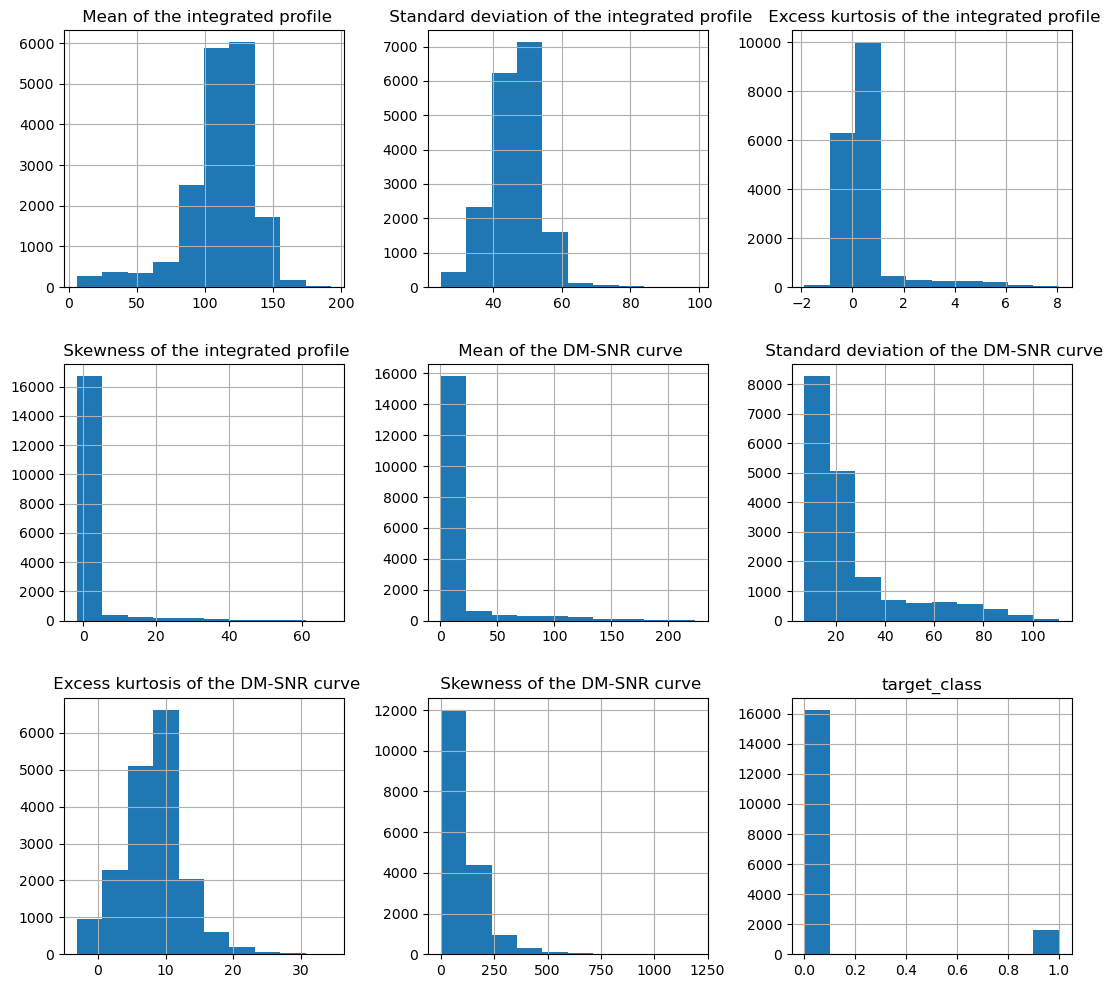

In [6]:
# Observando a distribuição dos dados
df_orginal.hist(figsize=(13, 12))

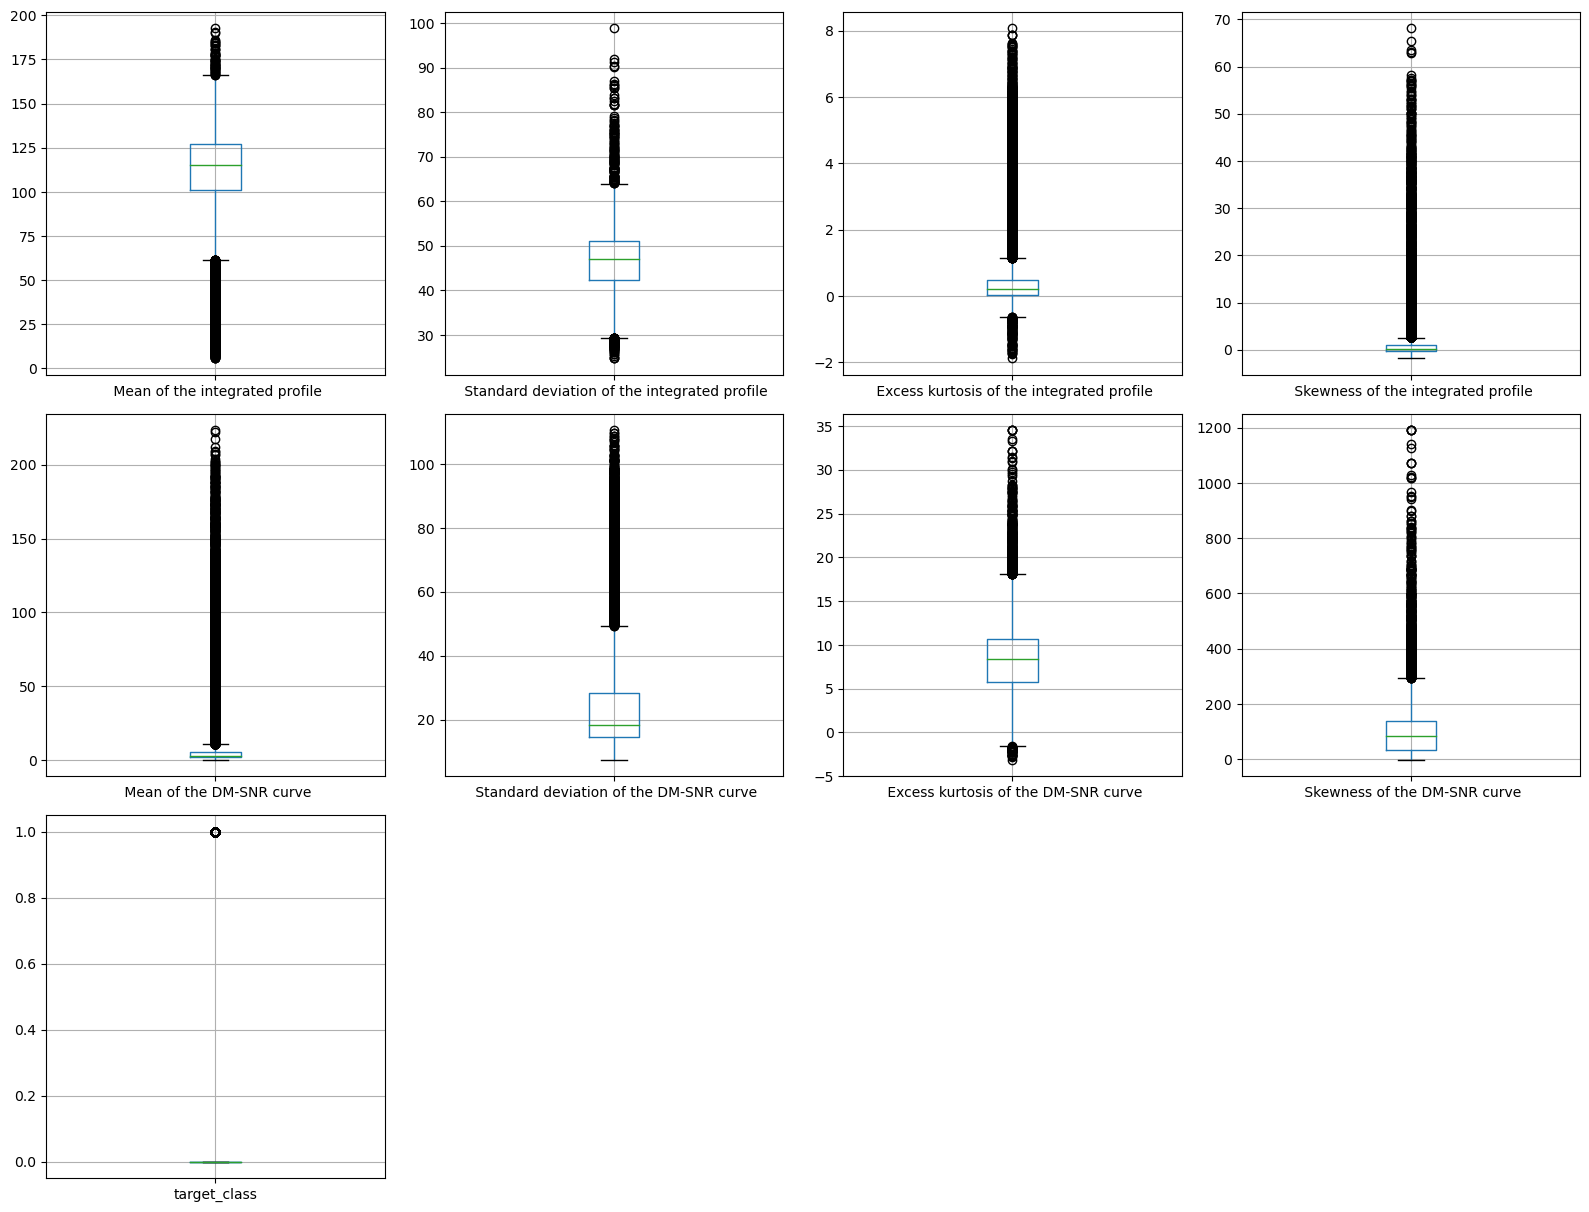

In [7]:
# Observando a distribuição dos dados através do boxplot. A procura de outliers.
# Foi observado qeu a variável dependente "target_class" possui poucos valores verdadeiros (1) e muitos negativos (0) 
plt.figure(figsize=(16 , 16))
for i, col in enumerate(df_orginal.columns):
    plt.subplot(4, 4, i + 1)
    df_orginal.boxplot(col)
    plt.tight_layout()

In [8]:
# Observando os valores da variávei dependente mais de perto
(df_orginal.target_class.value_counts() / df_orginal.shape[0]) * 100
# É possível que surjam problemas pelo desbalanceamento das classes. Vamos resolver isso mais adiante!

0    90.842552
1     9.157448
Name: target_class, dtype: float64

In [9]:
# Renomeando as variáveis para facilitar a manipulação
new_df = df_orginal.copy()

new_df.columns = new_df.columns.str.lower()
new_df.columns = new_df.columns.str.strip()
new_df.columns = new_df.columns.str.replace(" ", "_")
new_df.columns = new_df.columns.str.replace("-", "_")

<AxesSubplot:>

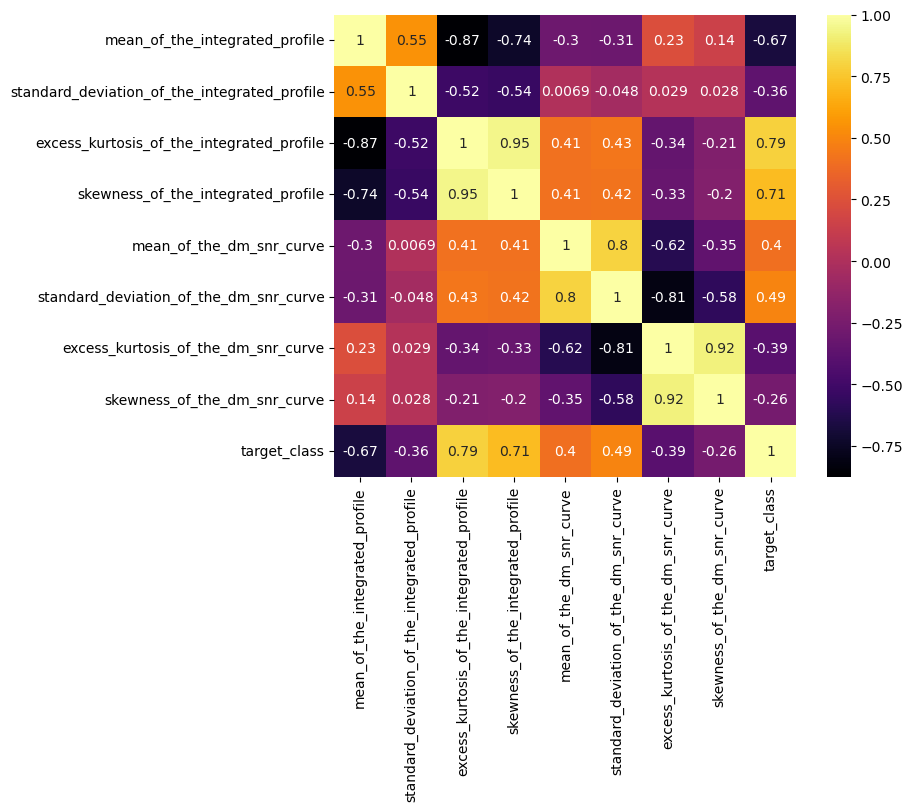

In [10]:
# Observando a correlação entre as variáveis. Temos bastante variáveis correlacionadas com a "target_class".
corr = new_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='inferno')

## Preparação dos dados

In [11]:
# Dependência necessária para realizar os passos abaixo
# !pip install imblearn

### Criação de novas amostras para balancear os dados no dataset

<p>
    Devido o desbalanceamento das variáveis dependentes, é necessário utilizar alguma técnica que balancerá para o modelo ter amostras suficientes de ambos os cenários (0 e 1).

    Por ser um dataset relativamente simples e que está sendo utilizado dentro do ambiente acadêmico, a técnica esclhida para realizar o balanceamento das classes foi a "over sampling".
</p>

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE

# Função onde é possível selecionar as features desejadas para o modelo
def return_features(features):

    seed = 10

    X = new_df[features]
    y = new_df[["target_class"]]

    smote_bal = SMOTE(random_state = seed)

    X_res, y_res = smote_bal.fit_resample(X, y)

    X = X_res
    y = y_res

    print(y.value_counts())

    return (X, y)

In [13]:
# Função onde é retornado todas as features para serem usadas no modelo.
def return_all_features():
    
    seed = 10

    X = new_df.drop("target_class", axis=1)
    y = new_df[["target_class"]]

    smote_bal = SMOTE(random_state = seed)

    X_res, y_res = smote_bal.fit_resample(X, y)

    X = X_res
    y = y_res

    print(y.value_counts())

    return (X, y)

In [14]:
# Todas as features após o balanceamento.
X, y = return_all_features()

target_class
0               16259
1               16259
dtype: int64


In [15]:
X.shape

(32518, 8)

In [16]:
# Transformação das variáveis independentes (X) para um range de 0 - 1 para facilitar o processamento da rede.
min_max_scaler = MinMaxScaler()
X_min_max_scaled = min_max_scaler.fit_transform(X)

In [17]:
# Divisão do dataset em treino e teste. Dataset de teste com 20%.
X_train, X_test, y_train, y_test = train_test_split(X_min_max_scaled, y, test_size=0.20, random_state=42)

In [18]:
tf.random.set_seed(42)

In [19]:
X.shape

(32518, 8)

## Criação do primeiro modelo

Epoch 1/100


2022-10-28 00:37:23.628524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/CustomEnvironments/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


789/813 [============================>.] - ETA: 0s - loss: 0.5654 - accuracy: 0.7431

/opt/anaconda3/envs/CustomEnvironments/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


813/813 [==============================] - 1s 1ms/step - loss: 0.5602 - accuracy: 0.7476 - val_loss: 0.3890 - val_accuracy: 0.8979
Epoch 2/100
813/813 [==============================] - 1s 875us/step - loss: 0.3331 - accuracy: 0.9154 - val_loss: 0.2869 - val_accuracy: 0.9274
Epoch 3/100
813/813 [==============================] - 1s 737us/step - loss: 0.2645 - accuracy: 0.9262 - val_loss: 0.2446 - val_accuracy: 0.9319
Epoch 4/100
813/813 [==============================] - 1s 751us/step - loss: 0.2338 - accuracy: 0.9295 - val_loss: 0.2247 - val_accuracy: 0.9307
Epoch 5/100
813/813 [==============================] - 1s 738us/step - loss: 0.2170 - accuracy: 0.9307 - val_loss: 0.2110 - val_accuracy: 0.9334
Epoch 6/100
813/813 [==============================] - 1s 737us/step - loss: 0.2065 - accuracy: 0.9321 - val_loss: 0.2030 - val_accuracy: 0.9351
Epoch 7/100
813/813 [==============================] - 1s 733us/step - loss: 0.1996 - accuracy: 0.9332 - val_loss: 0.1986 - val_accuracy: 0.9336

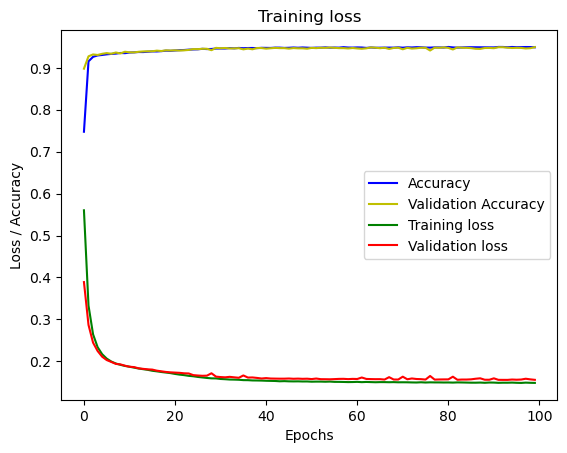

In [20]:
"""
    Essa configuração de rede neural teve um bom desempenho em comparação com as anteriores.
    Camadas escondidas e neurônios escolhidos sem critério. Apenas seguindo padrões da comunidade.
    Camada de saída com a função de ativação "sigmoid" para realizar a classificação binária (0 e 1)
"""
model_0 =  Sequential(
    [
        Dense(8, activation = 'relu'),
        Dense(4, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
)
"""
    Loss: BinaryCrossentropy - Função usada para classificação binária.
    Optimizer: Adam com o learning rate controlado com 0.001. 
    from_logits=True - (A documentação do tensorflow recomenda passar esse argumento)
    Metrics: Accuracy
"""
model_0.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)
"""
    epochs: 100 - valor escolhido com base na diminuição do loss.
"""
model_0.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)
# Validando acurácia e o loss
plot_lost_history(model_0.history)

## Criação do segundo modelo

### Seleção de features

In [21]:
# Escolhendo features com base na correlação entre as variáveis independentes (X) com a dependente (y).
columns = ["mean_of_the_integrated_profile", "excess_kurtosis_of_the_integrated_profile", "skewness_of_the_integrated_profile", "mean_of_the_dm_snr_curve", "excess_kurtosis_of_the_dm_snr_curve"]
X, y = return_features(columns)


target_class
0               16259
1               16259
dtype: int64


In [22]:
X.shape

(32518, 5)

In [23]:
X_min_max_scaled = min_max_scaler.fit_transform(X)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_min_max_scaled, y, test_size=0.20, random_state=42)

Epoch 1/100


/opt/anaconda3/envs/CustomEnvironments/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


813/813 [==============================] - 1s 900us/step - loss: 0.4407 - accuracy: 0.8668 - val_loss: 0.3354 - val_accuracy: 0.9200
Epoch 2/100
  1/813 [..............................] - ETA: 0s - loss: 0.3771 - accuracy: 0.8125

/opt/anaconda3/envs/CustomEnvironments/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


813/813 [==============================] - 1s 787us/step - loss: 0.2485 - accuracy: 0.9236 - val_loss: 0.2017 - val_accuracy: 0.9307
Epoch 3/100
813/813 [==============================] - 1s 778us/step - loss: 0.1979 - accuracy: 0.9291 - val_loss: 0.1933 - val_accuracy: 0.9322
Epoch 4/100
813/813 [==============================] - 1s 777us/step - loss: 0.1938 - accuracy: 0.9292 - val_loss: 0.1919 - val_accuracy: 0.9320
Epoch 5/100
813/813 [==============================] - 1s 775us/step - loss: 0.1921 - accuracy: 0.9296 - val_loss: 0.1898 - val_accuracy: 0.9331
Epoch 6/100
813/813 [==============================] - 1s 792us/step - loss: 0.1907 - accuracy: 0.9311 - val_loss: 0.1887 - val_accuracy: 0.9334
Epoch 7/100
813/813 [==============================] - 1s 899us/step - loss: 0.1892 - accuracy: 0.9318 - val_loss: 0.1896 - val_accuracy: 0.9339
Epoch 8/100
813/813 [==============================] - 1s 851us/step - loss: 0.1880 - accuracy: 0.9322 - val_loss: 0.1859 - val_accuracy: 0.93

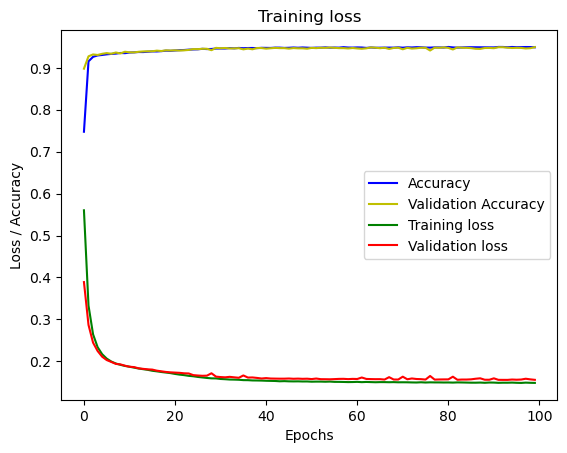

In [24]:
"""
    Essa configuração de rede neural teve um bom desempenho em comparação com as anteriores.
    Os neurônios das camadas foram reduzidos devido ao número reduzido de features.
    Camada de saída com a função de ativação "sigmoid" para realizar a classificação binária (0 e 1)
"""
model_1 =  Sequential(
    [
        Dense(5, activation = 'relu'),
        Dense(3, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
)
"""
    Loss: BinaryCrossentropy - Função usada para classificação binária.
    Optimizer: Adam com o learning rate controlado com 0.001. 
    from_logits=True - (A documentação do tensorflow recomenda passar esse argumento)
    Metrics: Accuracy
"""
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)
"""
    epochs: 100 - valor escolhido com base na diminuição do loss. (Foi mantido o valor da rede anterior)
"""
model_1.fit(
    X_train_1,y_train_1,
    epochs=100,
    validation_data=(X_test_1, y_test_1)
)

plot_lost_history(model_0.history)

## Comparando o desempenho dos modelos

### Primeiro modelo

In [25]:
y_hat = model_0.predict(X_test)
predicted = append_to_binary_results(y_hat, .55)
predicted = predicted.numpy().flatten()
report(y_test, predicted)

204/204 [==============================] - 0s 441us/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3314
           1       0.91      0.94      0.93      3190

    accuracy                           0.93      6504
   macro avg       0.93      0.93      0.93      6504
weighted avg       0.93      0.93      0.93      6504



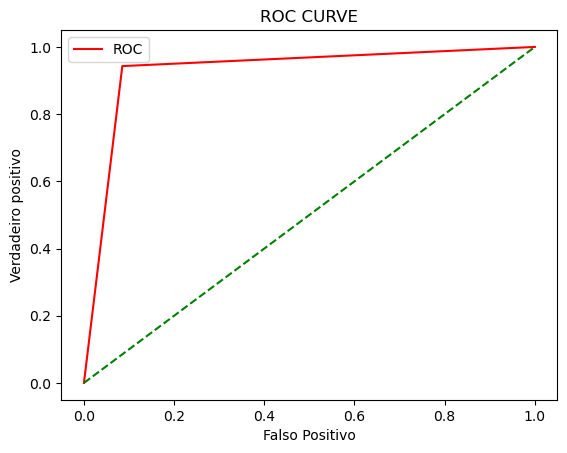

In [26]:
plot_roc_curve(y_test, predicted)

### Segundo modelo

In [27]:
y_hat = model_1.predict(X_test_1)
predicted = append_to_binary_results(y_hat, .55)
predicted = predicted.numpy().flatten()
report(y_test, predicted)

204/204 [==============================] - 0s 450us/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3314
           1       0.91      0.94      0.93      3190

    accuracy                           0.93      6504
   macro avg       0.93      0.93      0.93      6504
weighted avg       0.93      0.93      0.93      6504



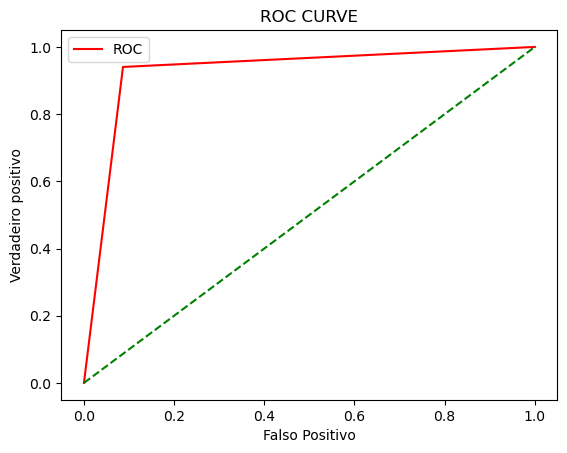

In [28]:
plot_roc_curve(y_test, predicted)

## Conclusão


Ambos os modelos fizeram boas predições das duas classes (0, 1). Com o balanceamento das classes, foi possível diminuir a possibilidade de "overfitting". 

No segundo modelo, foi utilizado menos variáveis independentes e neurônios para realizar a predição e foi obtido um desempenho tão satisfatório quanto ao do primeiro modelo, que utiliza todas as variáveis do dataset.

Sendo assim, é preferível utilizar o segundo modelo, pois será economizado recursos (memória e cpu) e tempo de treinamento.